In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import os
import glob
import json
import shutil
import math

#pip install analytic_wfm
from analytic_wfm.peakdetect import *
import cloudpickle
from datetime import datetime
import time

from sklearn.cluster import KMeans, k_means
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

%run "Fonctions.ipynb"
%run "Signal.ipynb"

In [2]:
pd.set_option('display.max_columns', 1000)

In [3]:
# Copie des fichiers .event pour aide export en .txt
copy_event_file("..\Millau\Resultats")
# copy_event_file("..\Normandie")

In [4]:
# Sélection des meilleurs signaux pour chacun des camions représentés par un fichier .txt
trucks_millau = select_all_best_signal('../Millau/Resultats/All_event', backup_path="backup/backup_trucks_millau.json")
# trucks_normandie = select_all_best_signal('../Normandie/All_event', backup_path="backup/backup_trucks_normandie.json")

In [5]:
# Récupération des csv contenant les informations de charges
millau = pd.read_csv('../Millau/Resultats/Fichiers Excel/millau_df_model.csv', index_col=0)
# normandie = pd.read_csv('../Normandie/Fichiers Excel/normandie_df_model.csv', index_col=0)

### Résultats dynamiques

In [16]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau_dyn = find_trucks_in_csv(trucks_millau, millau, "backup_trucks_coor_millau_dyn.json")
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json

In [17]:
# Création des class Signal
trucks_sig_millau_dyn = create_signal_instance(trucks_coor_millau_dyn, filename="class_trucks_millau_dyn.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [18]:
# Création DataFrame global Millau
all_df_dyn = pd.DataFrame()
for key, value in trucks_sig_millau_dyn.items():
    if (len(value.peaks) > 2) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df_dyn = pd.concat([all_df_dyn, value], sort=True)
all_df_dyn = all_df_dyn.reset_index(drop=True).sort_index()

Le pic 4.9707 du signal 2017-06-20-12-31-25-246 a eu un problème sur le calcul des fwhms.


In [19]:
# Remplacer 'max' par 1 et 'min' par 2
all_df_dyn.replace(to_replace='max', value=1, inplace=True)
all_df_dyn.replace(to_replace='min', value=2, inplace=True)

In [20]:
all_df_dyn = pd.concat([timestamp_dummies(all_df_dyn['name']), all_df_dyn], axis=1)
all_df_dyn.drop(['name'], axis=1, inplace = True)

In [21]:
#Normalisation des données
#all_df_norm = all_df.apply(lambda x: (x-np.mean(x))/(1e-10+np.std(x)))

In [22]:
# Complétion NaN
all_df_dyn.fillna(0, inplace=True)

#### Selection X et Y

In [24]:
loads = list_multiple_var('load_', var_to=8)
y_dyn = all_df_dyn[loads]
X_dyn = all_df_dyn.drop(loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde', 'longueur'], axis = 1)

### Résultats statiques

In [6]:
millau_statique = pd.read_csv("../Millau/Resultats/Fichier statique/millau_statique.csv", sep=";")
millau_statique_date = timestamp_dummies(millau_statique.date)

millau_statique.drop(['date'], axis=1, inplace=True)
millau_statique = pd.concat([millau_statique_date, millau_statique], axis=1)

In [7]:
# Trouver les correspondances entre les nswd et les event
trucks_coor_millau_stat = find_trucks_in_csv(trucks_millau, millau_statique, "backup_trucks_coor_millau_stat.json", statique=True)
# trucks_coor_normandie = find_trucks_in_csv(trucks_normandie, normandie, "backup_trucks_coor_normandie.json")

In [8]:
# Création des class Signal
trucks_sig_millau_stat = create_signal_instance(trucks_coor_millau_stat, filename="class_trucks_millau_stat.sig")
#trucks_sig_normandie = create_signal_instance(trucks_coor_normandie, filename="class_trucks_normandie.sig")

In [9]:
# Création DataFrame global Millau
all_df_stat = pd.DataFrame()
for key, value in trucks_sig_millau_stat.items():
    if (len(value.peaks) > 2) & (len(value.peaks) < 12):
        value = pd.concat([value.to_df(), pd.DataFrame([len(value.peaks)], columns=["longueur"])], axis=1)
        all_df_stat = pd.concat([all_df_stat, value], sort=True)
all_df_stat = all_df_stat.reset_index(drop=True).sort_index()

In [10]:
# Remplacer 'max' par 1
all_df_stat.replace(to_replace='max', value=1, inplace=True)

# Remplacer 'min' par 2
all_df_stat.replace(to_replace='min', value=2, inplace=True)

In [11]:
all_df_stat = pd.concat([timestamp_dummies(all_df_stat['name']), all_df_stat], axis=1)
all_df_stat.drop(['name'], axis=1, inplace = True)

In [12]:
#Normalisation des données
#all_df_norm = all_df.apply(lambda x: (x-np.mean(x))/(1e-10+np.std(x)))

In [13]:
# Complétion NaN
all_df_stat.fillna(0, inplace=True)

#### Selection X et Y

In [14]:
loads_s = list_multiple_var('load_s_', var_to=6)
loads = list_multiple_var('load_d_', var_to=6)
y_stat = all_df_stat[loads_s]
X_stat = all_df_stat.drop(loads_s+loads+['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconde', 'Milliseconde', 'longueur'], axis = 1)

## Test de modèle

### Clustering

#### Prédiction des clusters

In [25]:
# Dynamique
kms_dyn = k_means(X_dyn, 4)
clusters_dyn = pd.DataFrame(kms_dyn[1], columns=['cluster'])

    ## Séparation des clusters
clt_dyn = []
for i in range(4):
    clt_dyn.append(clusters_dyn[clusters_dyn["cluster"] == i])
    

# Statique
kms_stat = k_means(X_stat, 4)
clusters_stat = pd.DataFrame(kms_stat[1], columns=['cluster'])

    ## Séparation des clusters
clt_stat = []
for i in range(4):
    clt_stat.append(clusters_stat[clusters_stat["cluster"] == i])

#### Affichage graphique

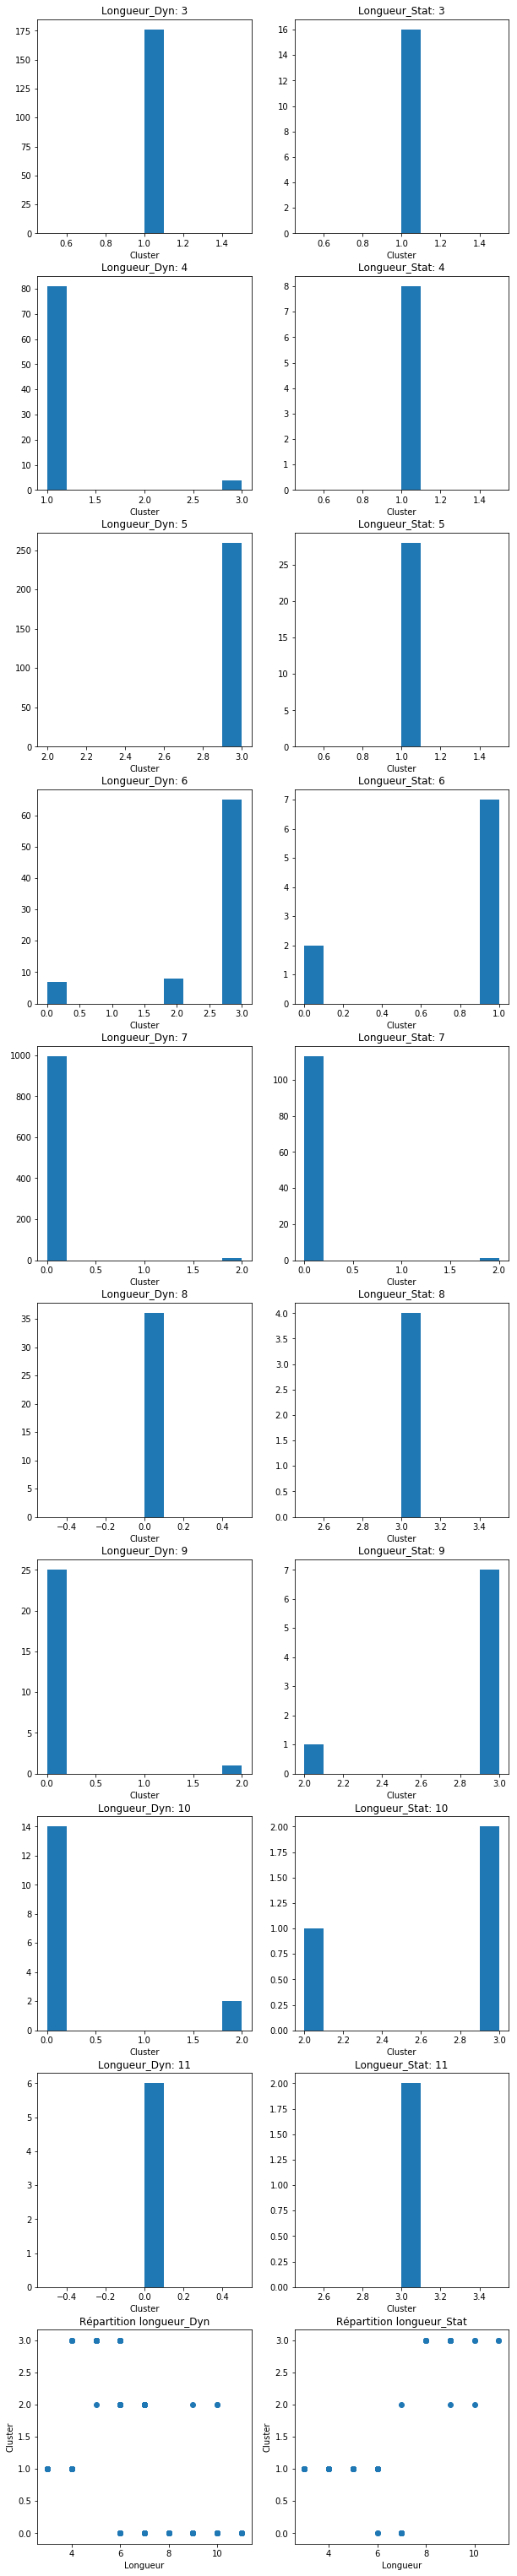

In [26]:
plt.figure(figsize=(10,55))

# Dynamique
len_for = pd.DataFrame(all_df_dyn['longueur']).apply(pd.value_counts).index.sort_values()
i=-1
for k in len_for:
    i+=2
    plt.subplot(len(len_for)+1, 2, i)
    plt.hist(clusters_dyn[all_df_dyn['longueur'] == k].T)
    plt.xlabel("Cluster")
    plt.title("Longueur_Dyn: " + str(k))
    
plt.subplot(len(len_for)+1, 2, i+2)
plt.scatter(all_df_dyn['longueur'], clusters_dyn.T)
plt.ylabel("Cluster")
plt.xlabel("Longueur")
plt.title("Répartition longueur_Dyn")

# Statique 
len_for = pd.DataFrame(all_df_stat['longueur']).apply(pd.value_counts).index.sort_values()
i=0
for k in len_for:
    i+=2
    plt.subplot(len(len_for)+1, 2, i)
    plt.hist(clusters_stat[all_df_stat['longueur'] == k].T)
    plt.xlabel("Cluster")
    plt.title("Longueur_Stat: " + str(k))
    
plt.subplot(len(len_for)+1, 2, i+2)
plt.scatter(all_df_stat['longueur'], clusters_stat.T)
plt.ylabel("Cluster")
plt.xlabel("Longueur")
plt.title("Répartition longueur_Stat")
plt.show()

### Modèle de prédiction

#### Modèle utilisé

In [27]:
class Model:
    def __init__(self, model, param, GS=False):
        self.model = model
        self.param = param
        self.GS = GS
        self.create_model()
        
        
    def fit(self, X_fit, y_fit):
        self.model.fit(X_fit, y_fit)
        
        
    def predict(self, X_predict):
        return self.model.predict(X_predict)
    
    
    def create_model(self, cv=5, scoring='neg_mean_squared_error', n_jobs=2):
        if not self.GS:
            for key, value in self.param.items():
                if type(value) == type(list()) and len(value) != 1:
                    print("Value of pram cannot be a list of multiple values.\nPass GS to True.")
                    break
                else:
                    self.model = self.model.set_params(**self.param)
        else:
            self.model = GridSearchCV(self.model, self.param, cv=cv, scoring=scoring, n_jobs=n_jobs)

        return self.model
    
    
    def best_score(self, y_train, y_test, y_train_predict, y_test_predict):
        if type(self.model) == GridSearchCV:
            print("Best score GS : ", -self.model.best_score_)
        
        # Score Train
        print("Erreur train : ", mean_squared_error(y_train, y_train_predict))
        # Score Test
        print("Erreur test : ", mean_squared_error(y_test, y_test_predict))
    
    
    def best_params(self):
        if type(self.model) == GridSearchCV:
            print("Best score GS : \n", self.model.best_params_)
        
        
    def visual(self, y, y_predict):
        return pd.concat([y.reset_index(drop=True), pd.DataFrame(y_predict)], axis=1)

In [28]:
# Modèle 1
model_1 = Ridge(random_state=42)
param_1 = {
    "alpha" : [6.0]}
clt_1 = Model(model_1, param_1, GS=True)

# Modèle 2
clt_2 = Model(model_1, param_1, GS=True)
# Modèle 3
clt_3 = Model(model_1, param_1, GS=True)
# Modèle 4
clt_4 = Model(model_1, param_1, GS=True)

#### Attribution des modèles aux données de clusters

In [29]:
# Dynamique
clusters_models_dyn = { # key : nbr cluster, value: modèle à utiliser
    0: clt_1,
    1: clt_2,
    2: clt_3,
    3: clt_4
}

# Séparation Train/Test et apprentissage des données
for key, value in clusters_models_dyn.items():
    X_train_dyn, X_test_dyn, y_train_dyn, y_test_dyn = train_test_split(X_dyn.iloc[clt_dyn[key].index, :], y_dyn.iloc[clt_dyn[key].index, :], test_size=0.2, random_state=42)
    value.fit(X_train_dyn, y_train_dyn)
    
    # Vérification modèle
    y_train_predict_dyn = value.predict(X_train_dyn)
    y_test_predict_dyn = value.predict(X_test_dyn)
    
    print("Dyn. Cluster : " + str(key+1))
    value.best_score(y_train_dyn, y_test_dyn, y_train_predict_dyn, y_test_predict_dyn)
    print("\n")

Dyn. Cluster : 1
Best score GS :  1.8200612111621826
Erreur train :  1.645848281994239
Erreur test :  1.570597118403975


Dyn. Cluster : 2
Best score GS :  5.244648098540328
Erreur train :  4.8907519340441015
Erreur test :  6.509390044226546


Dyn. Cluster : 3
Best score GS :  5.69917181776032
Erreur train :  1.736252819521953
Erreur test :  2.4778134069997444


Dyn. Cluster : 4
Best score GS :  2.9977272443304774
Erreur train :  2.570090844321512
Erreur test :  3.184261716247728




In [30]:
# Satique
clusters_models_stat = { # key : nbr cluster, value: modèle à utiliser
    0: clt_1,
    1: clt_2,
    2: clt_3,
    3: clt_4
}

# Séparation Train/Test et apprentissage des données
for key, value in clusters_models_stat.items():
    X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat.iloc[clt_stat[key].index, :], y_stat.iloc[clt_stat[key].index, :], test_size=0.2, random_state=42)
    value.fit(X_train_stat, y_train_stat)
    
    # Vérification modèle
    y_train_predict_stat = value.predict(X_train_stat)
    y_test_predict_stat = value.predict(X_test_stat)
    
    print("Stat. Cluster : " + str(key+1))
    value.best_score(y_train_stat, y_test_stat, y_train_predict_stat, y_test_predict_stat)
    print("\n")

Stat. Cluster : 1
Best score GS :  6.381564738385691
Erreur train :  5.416502975796103
Erreur test :  5.275435297640013


Stat. Cluster : 2
Best score GS :  7.062641244247784
Erreur train :  5.316241824030444
Erreur test :  5.81564479806433




ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: 2.

In [52]:
X_train_stat, X_test_stat, y_train_stat, y_test_stat = train_test_split(X_stat, y_stat, test_size=0.2, random_state=42)

#### Regression linéraire

In [53]:
rid = Ridge(random_state=42)
param = {
    "alpha" : [0.1, 0.5, 1.0],
    "max_iter" : [10, 100, 1000],
    "solver" : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'],
    "tol" : [0.1, 0.01, 0.001],
    "fit_intercept" : [True, False],
    "normalize" : [True, False],
    "copy_X" : [True, False]
}

In [54]:
clf = GridSearchCV(rid, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train_stat, y_train_stat)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': [0.1, 0.5, 1.0], 'max_iter': [10, 100, 1000], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga'], 'tol': [0.1, 0.01, 0.001], 'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [55]:
# Negate to have the MSE
-clf.best_score_

6.012042833533198

In [64]:
clf.best_params_

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 10,
 'normalize': False,
 'solver': 'saga',
 'tol': 0.1}

In [57]:
pred_X_train = clf.predict(X_train_stat)
pred_X_test = clf.predict(X_test_stat)

In [58]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train_stat, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test_stat, pred_X_test))

Erreur train :  5.355525539763491
Erreur test :  6.74000919849833


In [59]:
# Concat y_test | ^y_test
pd.concat([y_test_stat.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,7.0,9.8,9.4,9.5,9.3,0.0,6.469825,8.516350,4.062019,4.650332,4.205507,-0.023117
1,7.1,11.8,8.1,8.2,8.4,0.0,6.922118,9.788254,5.031394,5.236100,5.159077,0.197362
2,3.4,4.3,0.0,0.0,0.0,0.0,6.493895,8.953654,4.388828,4.883448,4.701090,-0.027243
3,6.9,11.2,4.2,4.3,4.2,0.0,6.437543,8.766997,4.329960,4.814049,4.613972,-0.046854
4,7.0,11.4,8.2,8.2,8.3,0.0,6.834447,9.499078,4.918545,5.207124,5.074448,0.159032
5,7.3,11.7,5.7,5.7,5.5,0.0,6.472921,8.549446,4.116601,4.698880,4.256898,-0.023041
6,6.3,5.3,4.7,4.6,0.0,0.0,6.642103,8.899168,4.524492,4.993073,4.714291,0.062012
7,5.7,9.2,0.0,3.5,3.5,0.0,6.612583,8.921527,4.331024,4.792088,4.445711,0.036980
8,7.4,11.3,7.8,7.7,8.1,0.0,6.892634,9.622660,5.200399,5.458482,5.423875,0.199054
9,6.7,8.9,5.6,5.1,4.7,0.0,6.752503,9.319922,4.622074,4.974865,4.742588,0.109927


#### ElasticNet

In [65]:
elsn = ElasticNet(random_state=42)
param = {
    "alpha" : [0.01, 0.05, 0.0001],
    "l1_ratio" : [0.1, 0.001, 0.01],
    "fit_intercept" : [True],
    "normalize" : [False],
    "precompute" : [True, False],
    "max_iter" : [20, 500, 1000],
    "copy_X" : [True],
    "tol" : [0.1, 0.01, 0.001],
    "warm_start" : [True, False],
    "positive" : [True, False],
    "selection" : ['cyclic', 'random'],
}

In [67]:
clf = GridSearchCV(elsn, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train_stat, y_train_stat)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'alpha': [0.01, 0.05, 0.0001], 'l1_ratio': [0.1, 0.001, 0.01], 'fit_intercept': [True], 'normalize': [False], 'precompute': [True, False], 'max_iter': [20, 500, 1000], 'copy_X': [True], 'tol': [0.1, 0.01, 0.001], 'warm_start': [True, False], 'positive': [True, False], 'selection': ['cyclic', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [68]:
# Negate to have the MSE
-clf.best_score_

6.0547341189361354

In [69]:
clf.best_params_

{'alpha': 0.05,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.01,
 'max_iter': 500,
 'normalize': False,
 'positive': True,
 'precompute': True,
 'selection': 'cyclic',
 'tol': 0.1,
 'warm_start': True}

In [70]:
pred_X_train = clf.predict(X_train_stat)
pred_X_test = clf.predict(X_test_stat)

In [71]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train_stat, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test_stat, pred_X_test))

Erreur train :  5.355054955525766
Erreur test :  6.614503188505357


In [72]:
# Concat y_test | ^y_test
pd.concat([y_test_stat.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,7.0,9.8,9.4,9.5,9.3,0.0,6.460522,8.575539,3.949095,4.573933,4.056574,-0.081011
1,7.1,11.8,8.1,8.2,8.4,0.0,6.946882,10.273438,5.011707,5.204837,5.009407,0.237225
2,3.4,4.3,0.0,0.0,0.0,0.0,6.380805,8.349599,3.985726,4.273913,3.818083,-0.032384
3,6.9,11.2,4.2,4.3,4.2,0.0,6.317713,8.072462,3.964033,4.272607,3.816931,-0.062100
4,7.0,11.4,8.2,8.2,8.3,0.0,6.833452,9.702485,4.926421,5.190625,4.990939,0.177255
5,7.3,11.7,5.7,5.7,5.5,0.0,6.443849,8.624666,3.994179,4.590862,4.115737,-0.085086
6,6.3,5.3,4.7,4.6,0.0,0.0,6.620048,8.747284,4.581266,5.085961,4.785795,0.035929
7,5.7,9.2,0.0,3.5,3.5,0.0,6.613962,9.107303,4.233228,4.755214,4.320946,-0.000724
8,7.4,11.3,7.8,7.7,8.1,0.0,6.858353,9.711726,5.366594,5.555477,5.531851,0.236796
9,6.7,8.9,5.6,5.1,4.7,0.0,6.781170,9.721988,4.568908,4.965517,4.624894,0.117401


#### RandomForestRegressor

In [105]:
rfr = RandomForestRegressor(random_state=42)
param = {
    "n_estimators" : [2000],
    "criterion" : ["mse", "mae"],
    "max_features" : ["sqrt", "log2", 0.1, 0.5, 0.9],
    "max_depth": [1, 5, 10, 15],
    "min_samples_split" : [2, 5, 10],
    "min_samples_leaf" : [1, 2, 3],
    "oob_score" : [True, False],
    "warm_start" : [True, False],
    "bootstrap" : [True]
}

In [106]:
clf = GridSearchCV(rfr, param, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train_stat, y_train_stat)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [2000], 'criterion': ['mse', 'mae'], 'max_features': ['sqrt', 'log2', 0.1, 0.5, 0.9], 'max_depth': [1, 5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3], 'oob_score': [True, False], 'warm_start': [True, False], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [107]:
# Negate to have the MSE
-clf.best_score_

6.099061215268

In [108]:
clf.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 1,
 'max_features': 0.1,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 2000,
 'oob_score': True,
 'warm_start': True}

In [109]:
pred_X_train = clf.predict(X_train_stat)
pred_X_test = clf.predict(X_test_stat)

In [110]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train_stat, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test_stat, pred_X_test))

Erreur train :  5.594482648222581
Erreur test :  6.7412900319121745


In [111]:
# Concat y_test | ^y_test
pd.concat([y_test_stat.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

,load_s_1,load_s_2,load_s_3,load_s_4,load_s_5,load_s_6,0,1,2,3,4,5
0,7.0,9.8,9.4,9.5,9.3,0.0,6.598912,9.004383,4.497779,4.801886,4.425555,0.059638
1,7.1,11.8,8.1,8.2,8.4,0.0,6.695300,9.314365,4.796135,5.101175,4.767526,0.084702
2,3.4,4.3,0.0,0.0,0.0,0.0,6.572124,8.966562,4.394419,4.710317,4.343030,0.036314
3,6.9,11.2,4.2,4.3,4.2,0.0,6.514670,8.757815,4.223858,4.495679,4.079473,0.038147
4,7.0,11.4,8.2,8.2,8.3,0.0,6.682226,9.259919,4.757503,5.057965,4.714800,0.087705
5,7.3,11.7,5.7,5.7,5.5,0.0,6.554737,8.841665,4.339013,4.604295,4.193447,0.057162
6,6.3,5.3,4.7,4.6,0.0,0.0,6.663946,9.212086,4.692163,5.022914,4.687379,0.069602
7,5.7,9.2,0.0,3.5,3.5,0.0,6.598406,9.029514,4.516716,4.810795,4.432219,0.060778
8,7.4,11.3,7.8,7.7,8.1,0.0,6.686285,9.276188,4.763238,5.072243,4.740612,0.085846
9,6.7,8.9,5.6,5.1,4.7,0.0,6.668798,9.226073,4.720425,5.027242,4.685026,0.082831


### XGBoost

In [ ]:
xgbr = xgb.XGBRegressor(random_state=42, n_jobs=2)
multioutpoutregressor = MultiOutputRegressor(xgbr)
param = {
    "estimator__max_depth": [1, 3, 10],
    "estimator__learning_rate": [0.01, 0.1, 1],
    "estimator__n_estimators": [150],
    "estimator__silent": [True, False],
    "estimator__objective": ['reg:linear'],
    "estimator__booster": ['gbtree', 'gblinear', 'dart'],
    "estimator__gamma": [0, 1, 10],
    "estimator__min_child_weight": [1, 5, 10],
    "estimator__max_delta_step": [0, 5, 10],
    "estimator__subsample": [0, 0.5, 0.9],
    "estimator__colsample_bytree": [0.1, 0.5, 1],
    "estimator__colsample_bylevel": [0.1, 0.5, 1],
    "estimator__reg_alpha": [0, 10],
    "estimator__reg_lambda": [1, 10],
    "estimator__scale_pos_weight": [1, 10],
    "estimator__base_score": [0, 0.5, 1]
}

In [ ]:
clf = GridSearchCV(multioutpoutregressor, param, cv=5, scoring='neg_mean_squared_error', n_jobs=2)
clf.fit(X_train, y_train)

In [ ]:
# Negate to have the MSE
-clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
pred_X_train = clf.predict(X_train)
pred_X_test = clf.predict(X_test)

In [ ]:
# Score Train
print("Erreur train : ", mean_squared_error(y_train, pred_X_train))
# Score Test
print("Erreur test : ", mean_squared_error(y_test, pred_X_test))

In [ ]:
# Concat y_test | ^y_test
pd.concat([y_test.reset_index(drop=True), pd.DataFrame(pred_X_test)], axis=1)

### Test répartition données

In [ ]:
kms = KMeans(init='k-means++', n_clusters=4, random_state=42)
kms.fit(X_train)

predicted = kms.predict(X_train)

#### Données liées

In [ ]:
# Centroïdes
print("Centroïdes:")
print(kms.cluster_centers_)
# Inertie
print("Inertie:")
print(kms.inertia_)
#Distance entre les 2 centroïdes
print("Distance centroïdes:")
print(sum((kms.cluster_centers_[0] - kms.cluster_centers_[1])**2))
#label
kms.label_

In [71]:
max_ = 5

ampl_name = list_multiple_var("amplitude_", var_from=0, var_to=max_)
fwhm_name = list_multiple_var("fwhm_", var_from=0, var_to=max_)
time_name = list_multiple_var("time_", var_from=0, var_to=max_)
kind_name = list_multiple_var("kind_", var_from=0, var_to=max_)
list_var = [ampl_name, fwhm_name, time_name, kind_name]

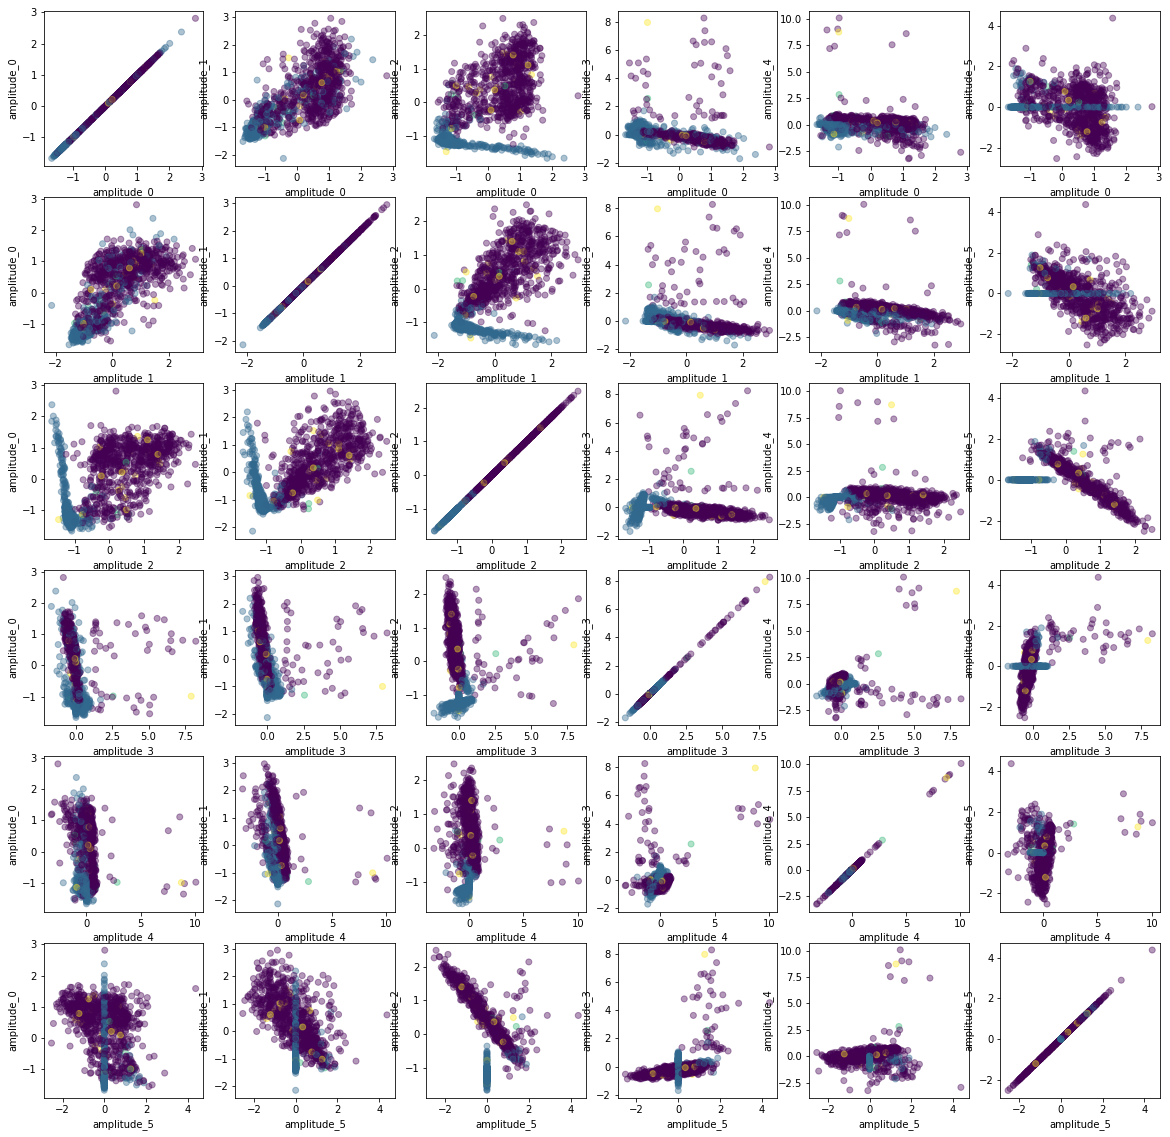

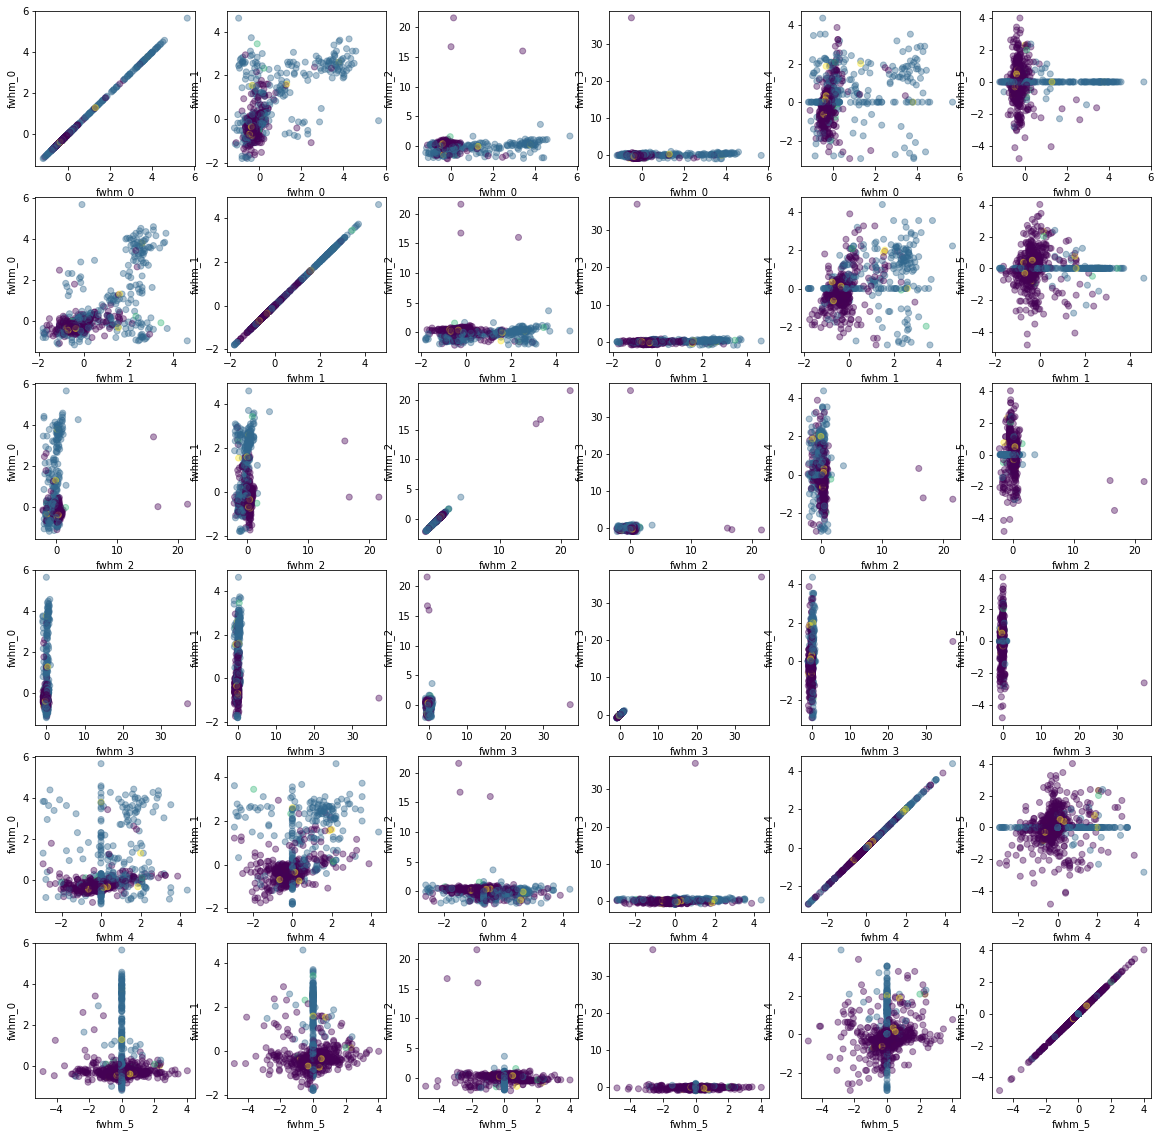

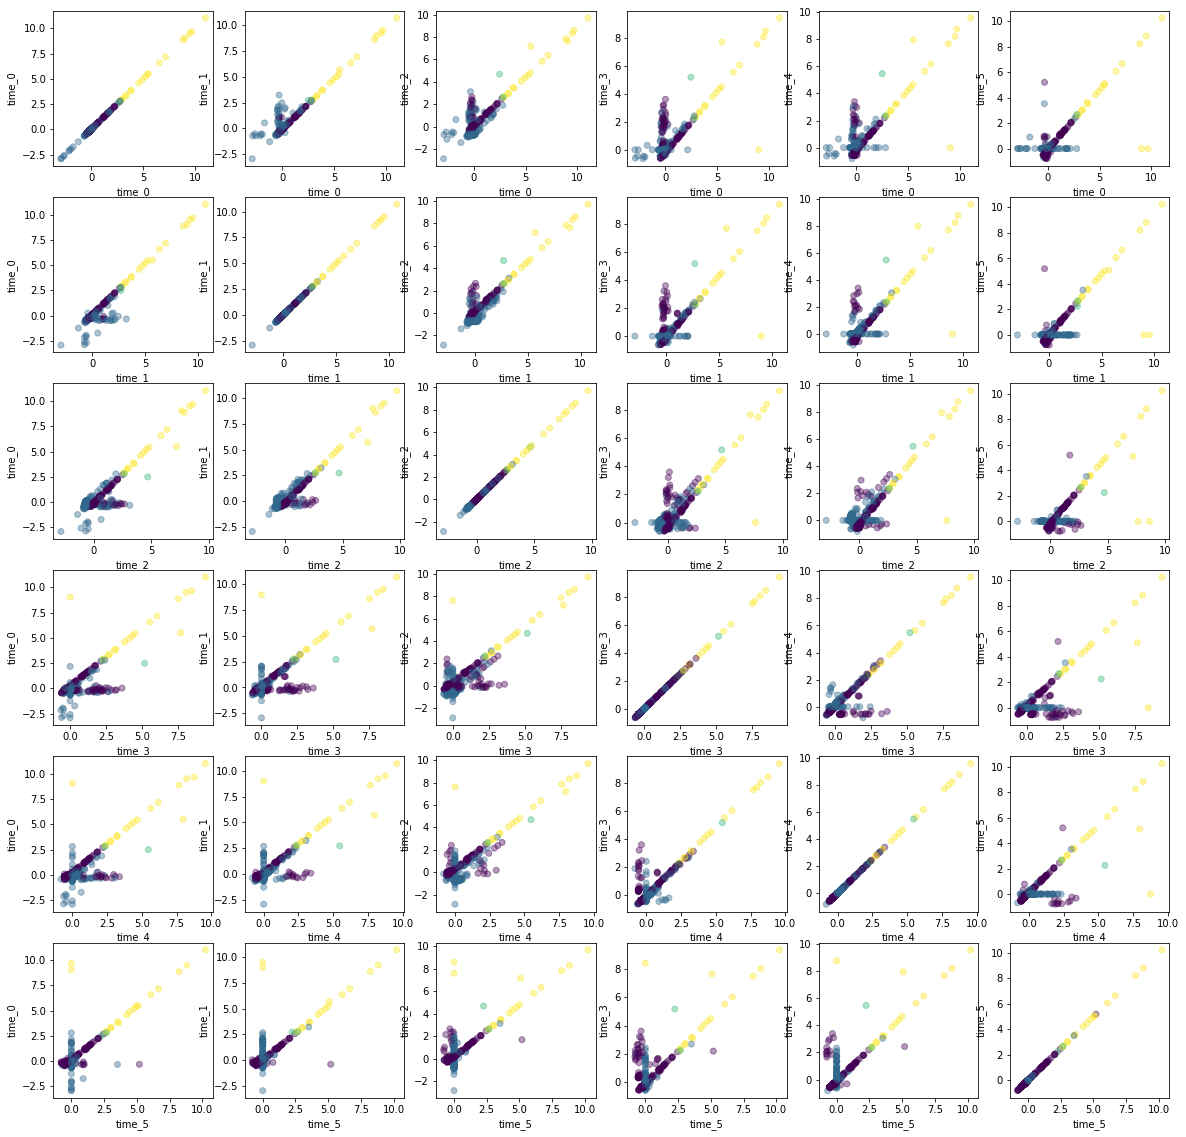

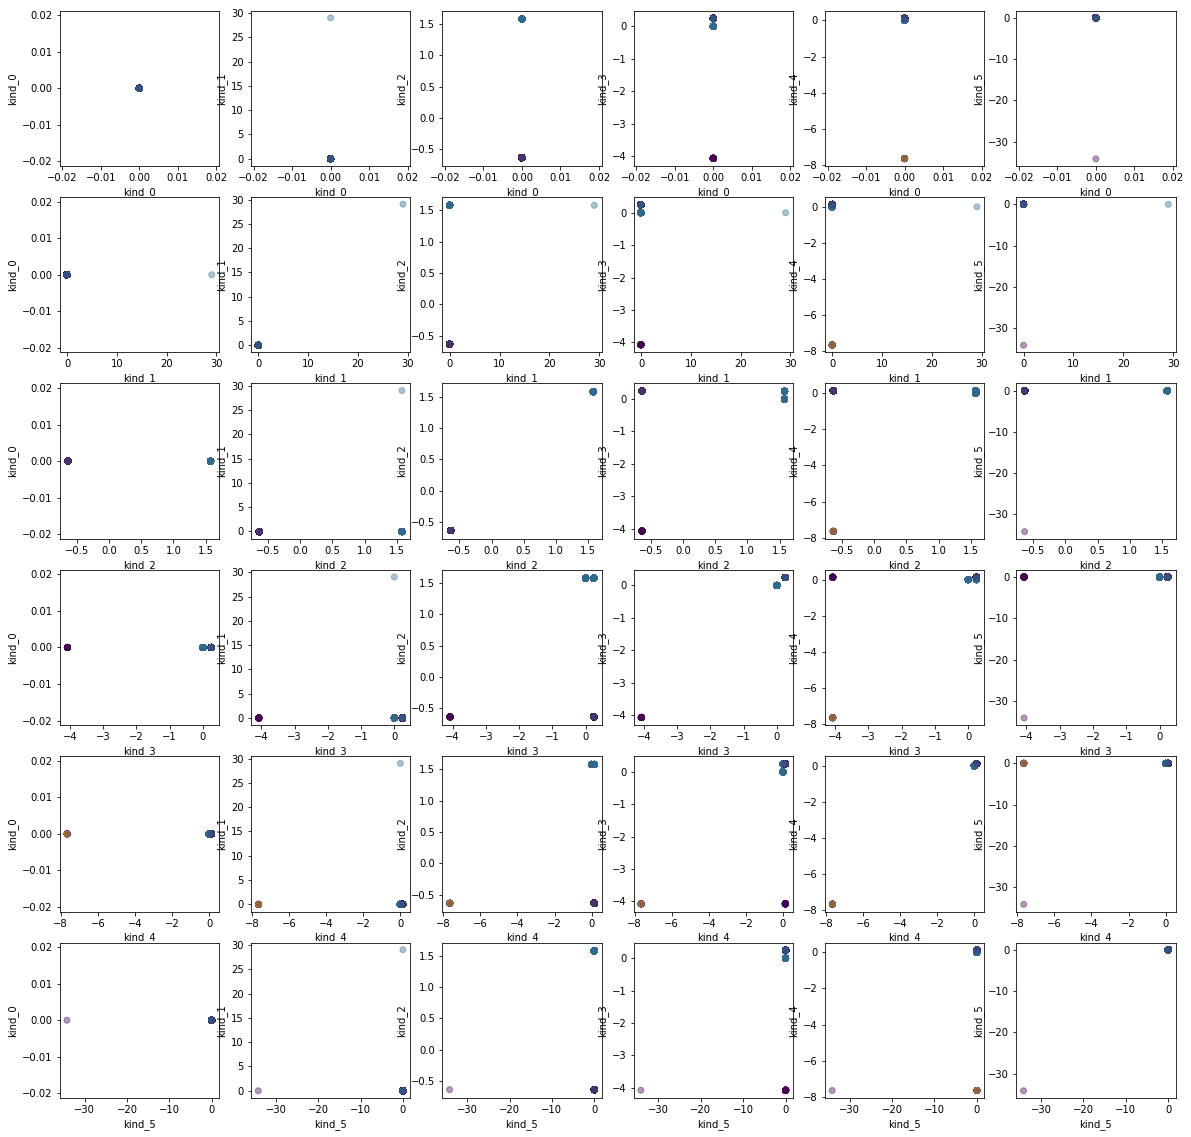

In [72]:
# Regrouppement variable par variable sur 5 élements
for var in list_var:
    plt.figure(figsize=(20,20))
    k=0
    for i in range(max_+1):
        for j in range(max_+1):
            k+=1
            plt.subplot(max_+1, max_+1, k)
            plt.scatter(X_train[var[i]], X_train[var[j]], c=predicted, alpha=0.4)
            plt.xlabel(var[i])
            plt.ylabel(var[j])

    plt.show()

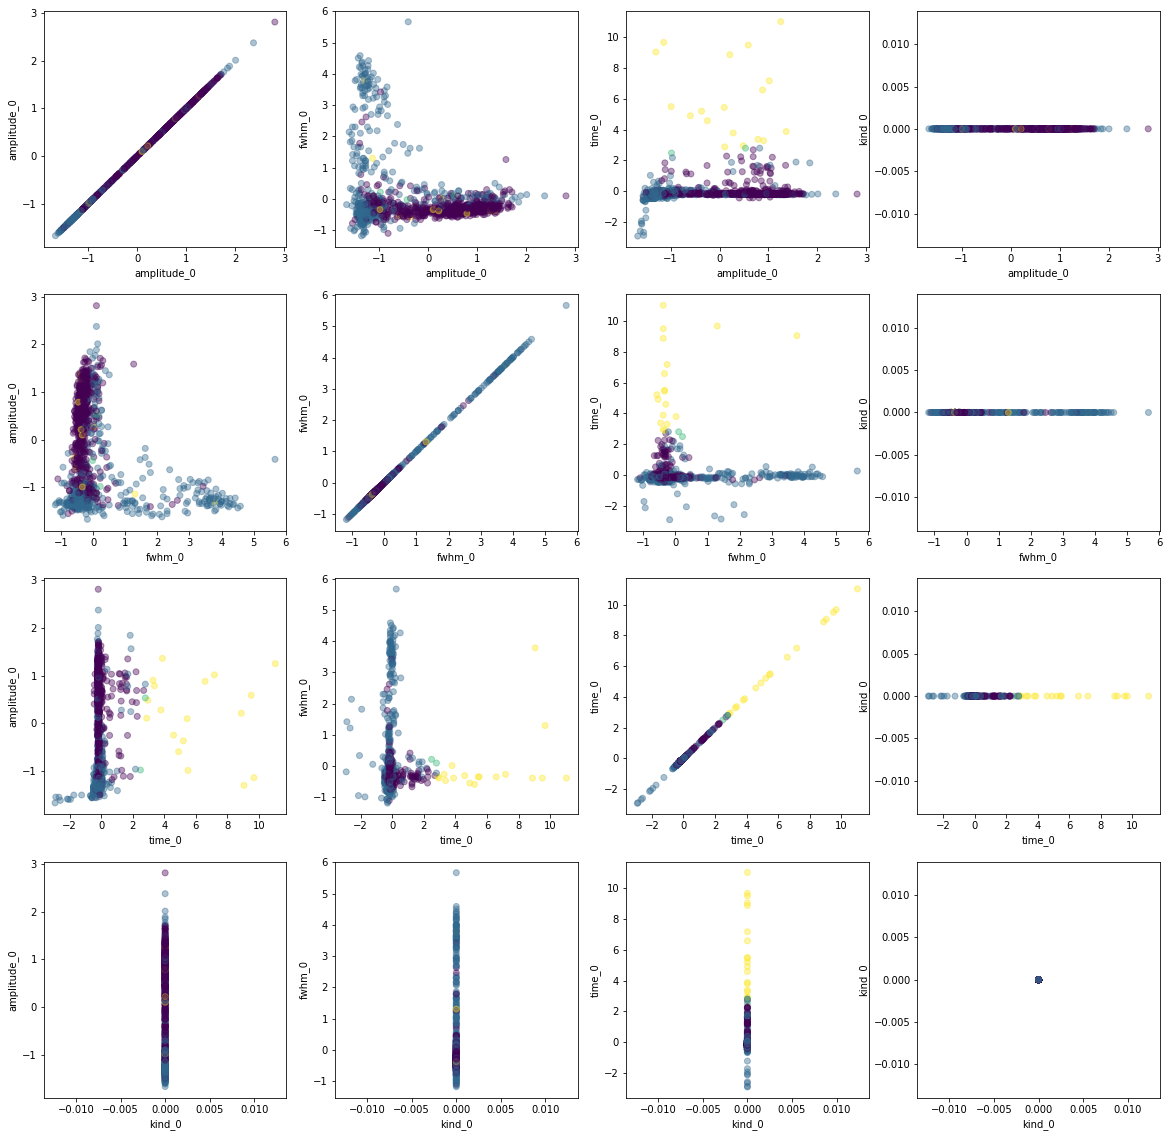

In [73]:
# Regroupement différente variables sur 1er élément
plt.figure(figsize=(20,20))
k=0
for i in list_var:
    for j in list_var:
        k+=1
        plt.subplot(len(list_var), len(list_var), k)
        plt.scatter(X_train[i[0]], X_train[j[0]], c=predicted, alpha=0.4)
        plt.xlabel(i[0])
        plt.ylabel(j[0])

plt.show()